# Projekt MSP1 / 2024
Cílem tohoto projektu je se seznámit s programovými nástroji využívaných ve statistice a osvojit si základní procedury. Projekt není primárně zaměřen na efektivitu využívání programového vybavení (i když úplně nevhodné konstrukce mohou mít vliv na hodnocení), ale nejvíce nás zajímají vaše statistické závěry a způsob vyhodnocení. Dbejte také na to, že každý graf musí splňovat nějaké podmínky - přehlednost, čitelnost, popisky.

V projektu budete analyzovat časy běhu šesti různých konfigurací algoritmů. Ke každé konfiguraci vzniklo celkem 200 nezávislých běhů, jejichž logy máte k dispozici v souboru [logfiles.zip](logfiles.zip).

Pokud nemáte rozchozené prostředí pro pro spouštění Jupyter notebooku, můžete využití službu [Google Colab](https://colab.google/). Jakákoliv spolupráce, sdílení řešení a podobně je zakázána!

S případnými dotazy se obracejte na Vojtěcha Mrázka (mrazek@fit.vutbr.cz).

__Odevzdání:__ tento soubor (není potřeba aby obsahoval výstupy skriptů) do neděle 27. 10. 2024 v IS VUT. Kontrola bude probíhat na Pythonu 3.12.3 (standardní instalace Ubuntu); neočekává se však to, že byste používali nějaké speciality a nekompatibilní knihovny. V případě nesouladu verzí a podobných problémů budete mít možnost reklamace a prokázání správnosti funkce. Bez vyplnění vašich komentářů a závěrů do označených buněk nebude projekt hodnocen!

__Upozornění:__ nepřidávejte do notebooku další buňky, odpovídejte tam, kam se ptáme (textové komentáře do Markdown buněk)

__Tip:__ před odevzdáním resetujte celý notebook a zkuste jej spustit od začátku. Zamezíte tak chybám krokování a editací, kdy výsledek z buňky na konci použijete na začátku.

__OTÁZKA K DOPLNĚNÍ:__

_Ondřej Lukášek, xlukas15_

**Testovací prostředí:**

* OS: MacOS Sequoia 15.0.1
* Python verze: 3.12.7

## Načtení potřebných knihoven
Načtěte knihovny, které jsou nutné pro zpracování souborů a práci se statistickými funkcemi.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from zipfile import ZipFile

## Načtení dat do DataFrame
Ze souboru `logfiles.zip` umístěném ve stejném adresáři načtěte data a vytvořte Pandas DataFrame.

Výsledky jsou uložené ve formátu JSON - pro zpracování použijte knihovnu `json`.
Můžete využít následující kostru - je vhodné pracovat přímo se ZIP souborem. Jedinou nevýhodou může být to, že vám bude vracet _byte_ objekt, který musíte přes funkci `decode` zpracovat.

Upravte také pomocí funkce `.astype()` datové typy patřičných sloupců.

```py
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # TODO test názvu souboru
        with zf.open(filename, "r") as f:
            pass # vytvořte slovník

df = pd.DataFrame(data)
df
```

In [2]:
data = []
with ZipFile("logfiles.zip") as zf:
    for filename in zf.namelist():
        # test nazvu souboru
        if filename.endswith(".json"):    
            with zf.open(filename, "r") as f:
                content = f.read().decode("utf-8")
                json_content = json.loads(content)
                data.append(json_content)

df = pd.DataFrame(data)

# pretypovani sloupcu - pouze kategorie, ostatni v poradku
df["configuration"] = df["configuration"].astype("category")
df["status"] = df["status"].astype("category")
df


,configuration,run,runtime,status
0,config6,149,53.733556,SUCCESS
1,config2,16,134.543496,SUCCESS
2,config6,180,117.108040,SUCCESS
3,config4,12,223.763044,SUCCESS
4,config5,193,159.540473,SUCCESS
...,...,...,...,...
1195,config5,95,199.461297,SUCCESS
1196,config5,99,155.491930,SUCCESS
1197,config2,83,125.243690,SUCCESS
1198,config5,153,223.312938,SUCCESS


## Analýza a čištění dat
Vhodným způsobem pro všechny konfigurace analyzujte časy běhů a pokud tam jsou, identifikujte hodnoty, které jsou chybné. Vyberte vhodný graf, který zobrazí samostatně jednotlivé konfigurace.

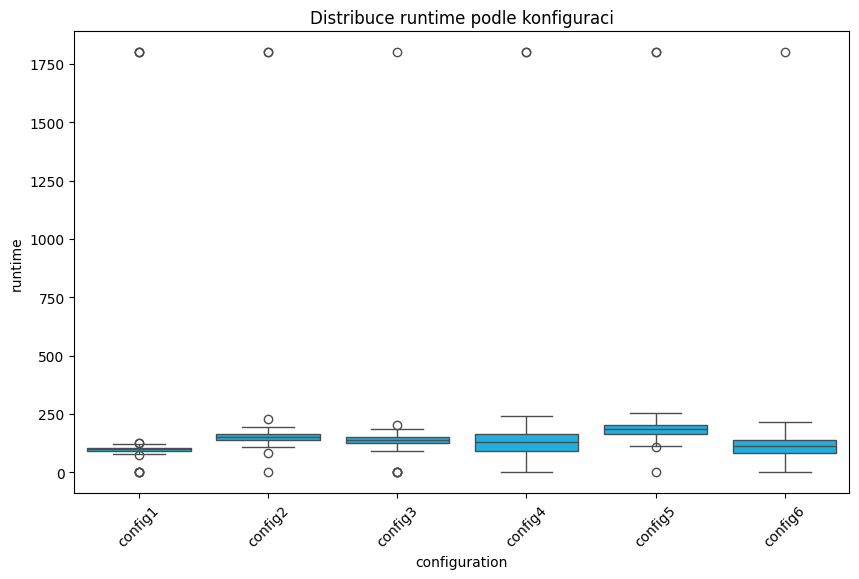

In [3]:
# jina barvicka pro hezci grafy
GRAPH_COLOR = "deepskyblue"

plt.figure(figsize = (10, 6))
sns.boxplot(x = "configuration", y = "runtime", data = df, color = GRAPH_COLOR)
plt.title("Distribuce runtime podle konfiguraci")
plt.xticks(rotation = 45)
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Objevily se nějaké chybné hodnoty? Proč tam jsou s ohledem na to, že se jedná o běhy algoritmů? Proč jste zvolili tento typ grafu?_

Ano, objevily. Chybné hodnoty se objevují ve sloupci `status`, kde hodnota nabývá `SEGFAULT` (hodnota u runtime je 0.0) nebo `TIME LIMIT` (runtime se rovná 1800.0). Tyto hodnoty se lze vyfiltrovat tím, že použiji pouze runtime hodnoty, které mají ve sloupci `status` hodnotu `SUCCESS`.

Tyto hodnoty se objevují zřejmě z důvodu, že běhy daného programu byly automaticky zapisované a pouze u nich byl zaznamenáván stav, v jakém algoritmus skončil.

Vybral jsem si boxplot, protože nejlépe ukazuje různé hodnoty, kdy box ukazuje, jaké hodnoty nabývá největší množství hodnot.
Uprostřed něj se nachází "čára", která ukazuje medián.
Čáry, vedoucí z boxu jsou potom odchylky od běžných hodnot - tedy hodnot nacházejících se mimo box
Jako poslední jsou ukázány outliers, což jsou hodnoty, které se významněji odchylují od všech ostatních hodnot. To může indikovat chybu.

Na grafu níže byly vykresleny již vyčištěné hodnoty a lze si jednoznačně všimnout, že graf vypadá znatelně lépe a smysluplněji. Například již nemají outliers pro všechny konfigurace stejnou hodnotu. Díky menšímu počtu hodně odlehlých hodnot se lze také v grafu lépe orientovat. Osa Y má totiž znatelně menší rozsah - <0; 250> místo původních <0; 1800>.

Vyčistěte dataframe `df` tak, aby tam tyto hodnoty nebyly a ukažte znovu analýzu toho, že čištění dat bylo úspěšné. Odtud dále pracujte s vyčištěným datasetem.

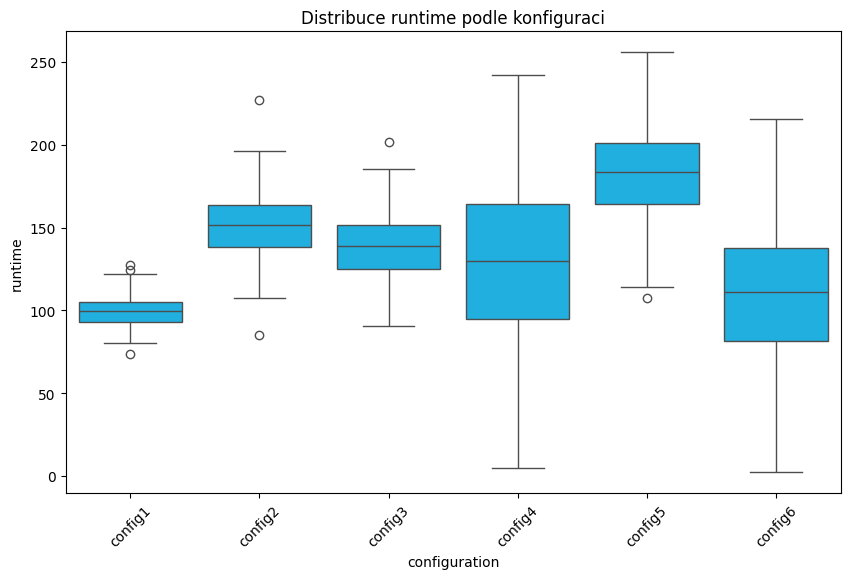

In [4]:
# jedina platna hodnota je SUCCESS, ostatni jsou chyby (SEGFAULT, TIME LIMIT)
df = df[df["status"] == "SUCCESS"]

plt.figure(figsize = (10, 6))
sns.boxplot(x = "configuration", y = "runtime", data = df, color = GRAPH_COLOR)
plt.title("Distribuce runtime podle konfiguraci")
plt.xticks(rotation = 45)
plt.show()

## Deskriptivní popis hodnot
Vypište pro jednotlivé konfigurace základní deskriptivní parametry.  

__TIP__ pokud výsledky uložíte jako Pandas DataFrame, zobrazí se v tabulce.

In [5]:
descriptive_params = df.groupby("configuration", observed = True)["runtime"].describe()

pd.DataFrame(descriptive_params)

,count,mean,std,min,25%,50%,75%,max
configuration,,,,,,,,
config1,193.0,99.590413,9.386788,73.802549,92.979469,99.865028,104.824724,127.201692
config2,197.0,151.732975,19.833198,85.174653,137.995662,151.516091,163.802880,227.054630
config3,195.0,138.616959,19.867428,90.567110,124.803901,138.678404,151.536291,201.577616
config4,196.0,127.606156,50.282164,4.970286,94.793688,129.975246,164.327163,241.987620
config5,197.0,183.659767,28.729836,107.283620,164.070091,183.843132,201.250693,255.807973
config6,199.0,110.422689,40.875754,2.124534,81.656211,111.043642,137.554141,215.295283


__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte, co všechno můžeme z parametrů vyčíst._

Tabulka zobrazuje následující sloupce:

* **count** - počet řádků (běhů) `df` pro každou z konfigurací (`config1-5`). Vzhledem k tomu, že jsou data vyčištěna se zde ukazují hodnoty pouze úspěšných běhů programu. Lze si všimnout, že nejvíce úspěšných běhů je u konfigurace 6 a nejméně u 1
* **mean** - průměrná délka `runtime` každé konfigurace. Lze si například všimnout toho, že nejdelší průměrný čas běhu má konfigurace 5 a nejnižší 1.
* **std** - udává směrodatnou odchylku, tedy říká, jak moc jsou hodnoty rozptýlené okolo průměru. Ukazuje to, jak moc konzistentní jednotlivé konfigurace jsou v rámci jejich běhů. To znamená, že čím menší odchylka, tím konzistentnější čas. Největší odchylku má konfigurace 4 a nejmenší konfigurace 1.
* **min** - Je to nejkratší doba běhu u každé z konfigurací. Tedy žádný průměr, prostě jedna nejnižší hodnota. Celkově běžel program nejkratší dobu v konfiguraci 6.
* **25%, 50%, 75%** - Udává hodnoty u konfigurací pro jednotlivé kvartily (pro 25%, 50%, tedy medián a 75%). První kvartil (25%) říká, že 25% běhů bylo kratších, než je tato hodnota. To samé platí pro medián (50%) a třetí kvartil (75%), jenom pro jiné procentuální hodnoty.
* **max** - Je to opak minimální doby běhu - tedy nejdelší doba běhu. Podle tabulky nejdéle program běžel v konfiguraci 5.

## Vizualizace
Vizualizujte časy běhů algoritmů tak, aby byl v jednom grafu zřejmý i rozptyl hodnot, avšak bylo možné porovnání. Zvolte vhodný graf, který pak níže komentujte.

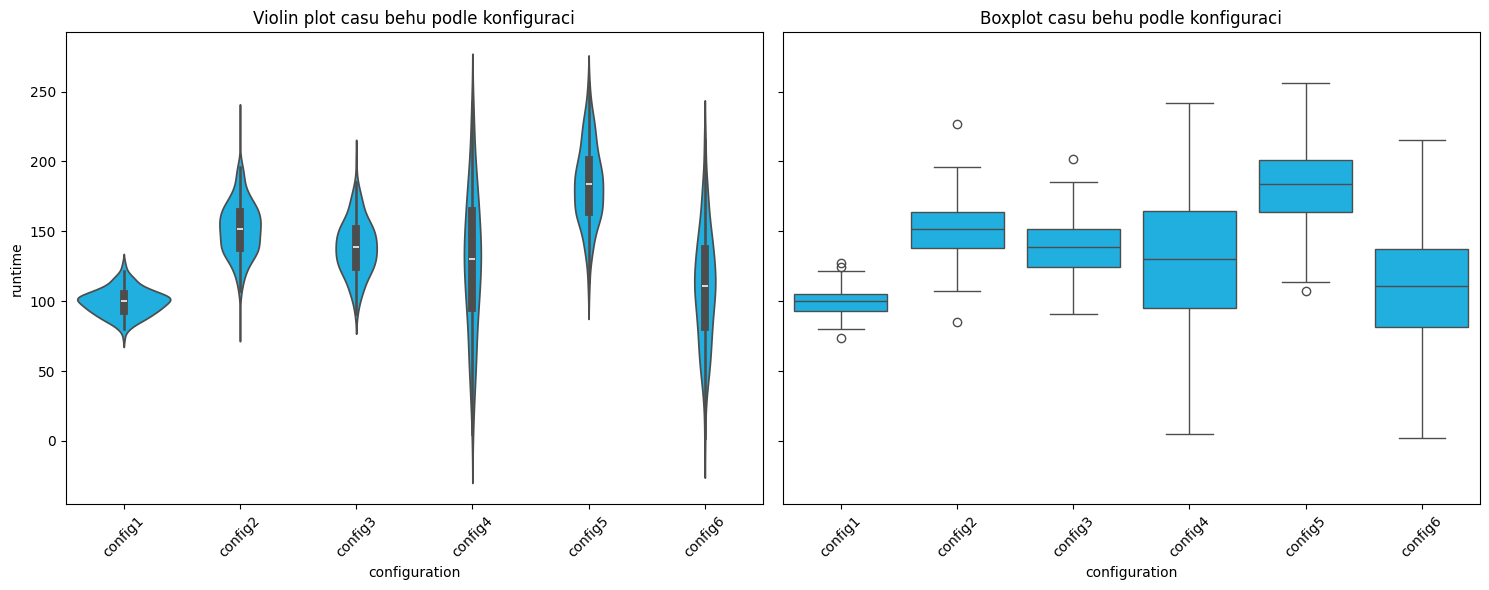

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6), sharex = True, sharey = True)

# Violin plot
sns.violinplot(ax = axes[0], x = "configuration", y = "runtime", data = df, color = GRAPH_COLOR)
axes[0].set_title("Violin plot casu behu podle konfiguraci")
axes[0].tick_params(axis = "x", rotation = 45)

# Boxplot
sns.boxplot(ax = axes[1], x = "configuration", y = "runtime", data = df, color = GRAPH_COLOR)
axes[1].set_title("Boxplot casu behu podle konfiguraci")
axes[1].tick_params(axis = "x", rotation = 45)

plt.tight_layout()
plt.show()

__OTÁZKA K DOPLNĚNÍ:__

_Okomentujte  výsledky z tabulky._

Nemohl jsem se jasně rozhodnout mezi tím, zda použít _violinplot_ nebo _boxplot_. Proto jsem naznal, že vykreslím oba a níže popíšu, v čem má který výhody a nevýhody. Oba grafy sdílejí stejnou osu `y`, takže je možné je mezi sebou dobře porovnat a vybrat si.

**Violinplot** se mi na první pohled zdál lepší, protože je lépe vidět hustota rozmístění dat. Takže lze například vidět, jestli pro danou konfiguraci neexistuje více vrcholů. Zároveň je tu však drobný problém s tím se v grafu vyznat, protože není úplně typický. Také nejsou tak dobře vidět outliers, respektive kolik jich je, vzhledem k tomu, že se violinplot zobrazuje k outliers jako "čára" dolů, případně nahoru.

**Boxplot** Je na první pohled trochu čitelnější - je lépe vidět, kde jsou vidět kvartily (25%, 50% a 75%). Zřetelněji jsou také vidět outliers. Nicméně narozdíl od violinplotu neukazuje tak detailní rozmístění dat a není tak možné vidět jejich detailnější tvar.

## Určení efektivity konfigurací algoritmů
Nás ale zajímá, jaká konfigurace je nejrychlejší. Z výše vykresleného grafu můžeme vyloučit některé konfigurace. Existuje tam však minimálně jedna dvojice, u které nedokážeme jednoznačně určit, která je lepší - pokud nebudeme porovnávat pouze extrémní hodnoty, které mohou být dané náhodou, ale celkově. Proto proveďte vhodný test významnosti - v následující části diskutujte zejména rozložení dat (i s odkazem na předchozí buňky, variabilitu vs polohu a podobně). Je nutné každý logický krok a výběry statistických funkcí komentovat. 

Využijte vhodnou funkci z knihovny `scipy.stats` a funkci poté __implementujte sami__ na základě základních matematických funkcí knihovny `numpy` případně i funkcí pro výpočet vybraného rozložení v [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html). Při vlastní implementaci není nutné se primárně soustředit na efektivitu výpočtu (není potřeba využít všechny funkce numpy, můžete použít normální cykly a podobně - v hodnocení však bude zahrnuta přehlednost a neměly by se objevit jasné chyby, jako je zvýšení třídy složitosti a podobně).

__OTÁZKA K DOPLNĚNÍ:__

_Jaká data budete zkoumat? Jaké mají rozložení a parametry (např. varianci) a jaký test použijete? Jaká je nulová hypotéza? Jak se liší variabilita a poloha vybraných konfigurací?_

Ze všeho nejdříve si vyberu data pro dané konfigurace, pro které nelze jednoznačně určit, která z nich je lepší. Podle pohledu na violinplot a boxplot výše se zdá, že nelze jednoznačně určit, zda je lepší konfigurace 1 nebo 6. Budu se tedy věnovat těmto dvěma konfiguracím.

Obě vypadají, že mají normální rozložení. Nicméně pouze vizuální kontrola nemusí být přesná. Proto jsem se ještě rozhodl otestovat rozložení pomocí Shapiro-Wilk testu. Nulová hypotéza tohoto testu říká, že data mají normální rozložení. Standardně se jako hranice pro zamítnutí hypotézy používá hladina významnosti  `0.05`. Výsledek (p-hodnoty) pro `config1` je `~0.83` a pro `config6` je to `~0.77`. Protože je výsledek Shapiro-Wilk testu vysoko nad touto hranicí, nemohu zamítnout nulovou hypotézu a tudíž data mají normální rozdělení. Tento test tedy potvrdil první domněnku o normálním rozdělení.

Tento fakt, že se jedná o normální rodělení, mi říká něco o tom, jak dále testovat. Nyní je totiž možné použít parametrické testy, které předpokládají, že data budou mít normální rozdělení. Zde jsem si vybral Welchův t-test.

Tento test se používá k porovnání průměrů dvou nezávislých vzorků dat. V mém případě ukazuje, jestli existuje *statisticky významný rozdíl mezi průměrnými časy běhů mých dvou vybraných konfirgurací*. Nulová hypotéza říká, že *průměrné časy běhů config1 a config6 jsou stejné*. Alternativní hypotéza pro test potom bude říkat, že *průměrné časy běhů konfigurací se liší*.

Pomocí dvouvýběrového t-testu porovnám časy běhů konfigurací a jako Hladinu významnosti si opět zvolím `0.05`. Tedy stejnou, jako u předchozího testu. Pokud bude naměřená p-hodnota nižší než `0.05`, mohu nulovou hypotézu zamítnout. To by znamenalo, že *existuje statisticky významný rozdíl mezi časy běhů konfigurací*. Pokud bude p-hodnota vyšší než `0.05`, pak nebude možné nulovou hypotézu zamítnout a *průměrné časy běhů se tak statisticky významně neliší*.

In [7]:
# vybereme data pro konfigurace 1 a 6
config1_data = df[(df["configuration"] == "config1")]["runtime"]
config6_data = df[(df["configuration"] == "config6")]["runtime"]

# Shapiro-Wilk test pro testovani normalniho rozdeleni
print("Shapiro-Wilk test:")
# test pro config1
stat, p_value = stats.shapiro(config1_data)
print(f"\tconfig1:")
print(f"\t\tstatistika = {stat}")
print(f"\t\tp-hodnota = {p_value}")

# test pro config6
stat, p_value = stats.shapiro(config6_data)
print(f"\tconfig6:")
print(f"\t\tstatistika = {stat}")
print(f"\t\tp-hodnota = {p_value}\n")

# Studentuv t-test
t_stat, p_value = stats.ttest_ind(config1_data, config6_data, equal_var = False)
print(f"Studentův t-test:")
print(f"\tt-statistika: {t_stat}")
print(f"\tp-hodnota: {p_value}")

Shapiro-Wilk test:
	config1:
		statistika = 0.9954743765602111
		p-hodnota = 0.834806135496018
	config6:
		statistika = 0.9950868815162216
		p-hodnota = 0.7656591016111877

Studentův t-test:
	t-statistika: -3.64068343471875
	p-hodnota: 0.00033918482758849635


__OTÁZKA K DOPLNĚNÍ:__

_Jaký je závěr statistického testu?_

Jak již bylo zmíněno v textovém poli výše, prvním Shapiro-Wilk testem jsem potvrdil, že data mají skutečně normální rozdělení (tedy bylo to otestováno nejen vizuálně). To mi umožnilo použít parametrické testy.

Z nich jsem se rozhodl testovat pomocí Welchova t-testu. Na základě jeho výsledků, kde `p-hodnota ~ -3.59` a `t-statistika ~ 0.000372` můžeme zamítnout nulovou hypotézu t-testu. To tedy znamená, že mezi průměrnými časy běhů `config1` a `config6` existuje statisticky výzmnamný rozdíl.

A vzhledem k záporné `t-statistice` lze také určit, že průměrný čas běhu běhu `config1` je kratší, než průměrný čas běhu `config6`. Při kladném čísle by zase byla rychlejší konfigurace 6.

### Vlastní implementace
Implementujte stejný test pomocí knihovních funkcí a ukažte, že je výsledek stejný.

In [10]:
# opet vybereme data pro config1 a config6
config1_data = df[(df["configuration"] == "config1")]["runtime"]
config6_data = df[(df["configuration"] == "config6")]["runtime"]

# budu implementovat pouze Welchuv t-test
# Shapiro-Wilk test jsem pouzil spis jen pro kontrolu normalniho rozdeleni
# konfigurace jsem v predchozim kroku porovnaval pouze Welchovym t-testem
def welch_t_test(config1, config2):
    # zjistime si delku obou konfiguraci
    len_c1 = len(config1)
    len_c2 = len(config2)

    # zjistime prumery obou konfiguraci
    mean_c1 = np.mean(config1)
    mean_c2 = np.mean(config2)

    # zjistime rozptyly obou konfiguraci
    # ddof = 1 -> stupne volnosti pro nezkresleny odhad rozptylu
    var_c1 = np.var(config1, ddof = 1)
    var_c2 = np.var(config2, ddof = 1)

    # vypocet t-statistiky
    # https://statistikajednoduse.cz/article/welchuv-test-dvouvyberovy
    t_stat = (mean_c1 - mean_c2) / np.sqrt((var_c1 / len_c1) + (var_c2 / len_c2))

    # vypocet stupnu volnosti podle Welchova vzorce:
    deg_free = ((var_c1 / len_c1) + (var_c2 / len_c2))**2 / (((var_c1 / len_c1)**2 / (len_c1 - 1)) + ((var_c2 / len_c2)**2 / (len_c2 - 1)))

    # vypocet p-hodnoty
    # pouzivam dvoustranny test -> nasobim 2
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), deg_free))

    return t_stat, p_value


# pro lepsi presnost lze zvysit pocet simulaci - tohle mi prislo dostatecne presne pro ukazku
# cisla jsou velice podobna
t_stat_custom, p_value = welch_t_test(config1_data, config6_data)
print("Vlastni Studentuv t-test:")
print(f"\tt-statistika: {t_stat_custom}")
print(f"\tp-hodnota: {p_value}\n")

t_stat, p_value = stats.ttest_ind(config1_data, config6_data, equal_var = False)
print("Scipy Studentuv t-test:")
print(f"\tt-statistika: {t_stat}")
print(f"\tp-hodnota: {p_value}")

Vlastni Studentuv t-test:
	t-statistika: -3.64068343471875
	p-hodnota: 0.0003391848275884346

Scipy Studentuv t-test:
	t-statistika: -3.64068343471875
	p-hodnota: 0.00033918482758849635
